<h1>1- Define The Ajax Based Calling To Youtube</h1>

In [6]:
from __future__ import print_function

import io
import json
import os
import sys
import time
from matplotlib import pyplot as plt 
import numpy as np
import argparse
import lxml.html
import requests
from lxml.cssselect import CSSSelector

YOUTUBE_VIDEO_URL = 'https://www.youtube.com/watch?v={youtube_id}'
YOUTUBE_COMMENTS_AJAX_URL_OLD = 'https://www.youtube.com/comment_ajax'
YOUTUBE_COMMENTS_AJAX_URL_NEW = 'https://www.youtube.com/comment_service_ajax'

USER_AGENT = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36'


def find_value(html, key, num_chars=2, separator='"'):
    pos_begin = html.find(key) + len(key) + num_chars
    pos_end = html.find(separator, pos_begin)
    return html[pos_begin: pos_end]


def ajax_request(session, url, params=None, data=None, headers=None, retries=5, sleep=20):
    for _ in range(retries):
        response = session.post(url, params=params, data=data, headers=headers)
        if response.status_code == 200:
            return response.json()
        if response.status_code in [403, 413]:
            return {}
        else:
            time.sleep(sleep)


def download_comments(youtube_id, sleep=.1):
    if r'\"isLiveContent\":true' in requests.get(YOUTUBE_VIDEO_URL.format(youtube_id=youtube_id)).text:
        print('Live stream detected! Not all comments may be downloaded.')
        return download_comments_new_api(youtube_id, sleep)
    return download_comments_old_api(youtube_id, sleep)


def download_comments_new_api(youtube_id, sleep=1):
    # Use the new youtube API to download some comments
    session = requests.Session()
    session.headers['User-Agent'] = USER_AGENT

    response = session.get(YOUTUBE_VIDEO_URL.format(youtube_id=youtube_id))
    html = response.text
    session_token = find_value(html, 'XSRF_TOKEN', 3)

    data = json.loads(find_value(html, 'window["ytInitialData"] = ', 0, '\n').rstrip(';'))
    for renderer in search_dict(data, 'itemSectionRenderer'):
        ncd = next(search_dict(renderer, 'nextContinuationData'), None)
        if ncd:
            break
    continuations = [(ncd['continuation'], ncd['clickTrackingParams'])]

    while continuations:
        continuation, itct = continuations.pop()
        response = ajax_request(session, YOUTUBE_COMMENTS_AJAX_URL_NEW,
                                params={'action_get_comments': 1,
                                        'pbj': 1,
                                        'ctoken': continuation,
                                        'continuation': continuation,
                                        'itct': itct},
                                data={'session_token': session_token},
                                headers={'X-YouTube-Client-Name': '1',
                                         'X-YouTube-Client-Version': '2.20200207.03.01'})

        if not response:
            break
        if list(search_dict(response, 'externalErrorMessage')):
            raise RuntimeError('Error returned from server: ' + next(search_dict(response, 'externalErrorMessage')))

        # Ordering matters. The newest continuations should go first.
        continuations = [(ncd['continuation'], ncd['clickTrackingParams'])
                         for ncd in search_dict(response, 'nextContinuationData')] + continuations

        for comment in search_dict(response, 'commentRenderer'):
            yield {'cid': comment['commentId'],
                   'text': ''.join([c['text'] for c in comment['contentText']['runs']]),
                   'time': comment['publishedTimeText']['runs'][0]['text'],
                   'author': comment.get('authorText', {}).get('simpleText', ''),
                   'channel': comment['authorEndpoint']['browseEndpoint']['browseId'],
                   'votes': comment.get('voteCount', {}).get('simpleText', '0'),
                   'photo': comment['authorThumbnail']['thumbnails'][-1]['url'],
                   'heart': next(search_dict(comment, 'isHearted'), False)}

        time.sleep(sleep)


def search_dict(partial, key):
    if isinstance(partial, dict):
        for k, v in partial.items():
            if k == key:
                yield v
            else:
                for o in search_dict(v, key):
                    yield o
    elif isinstance(partial, list):
        for i in partial:
            for o in search_dict(i, key):
                yield o


def download_comments_old_api(youtube_id, sleep=1):
    # Use the old youtube API to download all comments (does not work for live streams)
    session = requests.Session()
    session.headers['User-Agent'] = USER_AGENT

    # Get Youtube page with initial comments
    response = session.get(YOUTUBE_VIDEO_URL.format(youtube_id=youtube_id))
    html = response.text

    reply_cids = extract_reply_cids(html)

    ret_cids = []
    for comment in extract_comments(html):
        ret_cids.append(comment['cid'])
        yield comment

    page_token = find_value(html, 'data-token')
    session_token = find_value(html, 'XSRF_TOKEN', 3)

    first_iteration = True

    # Get remaining comments (the same as pressing the 'Show more' button)
    while page_token:
        data = {'video_id': youtube_id,
                'session_token': session_token}

        params = {'action_load_comments': 1,
                  'order_by_time': True,
                  'filter': youtube_id}

        if first_iteration:
            params['order_menu'] = True
        else:
            data['page_token'] = page_token

        response = ajax_request(session, YOUTUBE_COMMENTS_AJAX_URL_OLD, params, data)
        if not response:
            break

        page_token, html = response.get('page_token', None), response['html_content']

        reply_cids += extract_reply_cids(html)
        for comment in extract_comments(html):
            if comment['cid'] not in ret_cids:
                ret_cids.append(comment['cid'])
                yield comment

        first_iteration = False
        time.sleep(sleep)

    # Get replies (the same as pressing the 'View all X replies' link)
    for cid in reply_cids:
        data = {'comment_id': cid,
                'video_id': youtube_id,
                'can_reply': 1,
                'session_token': session_token}

        params = {'action_load_replies': 1,
                  'order_by_time': True,
                  'filter': youtube_id,
                  'tab': 'inbox'}

        response = ajax_request(session, YOUTUBE_COMMENTS_AJAX_URL_OLD, params, data)
        if not response:
            break

        html = response['html_content']

        for comment in extract_comments(html):
            if comment['cid'] not in ret_cids:
                ret_cids.append(comment['cid'])
                yield comment
        time.sleep(sleep)


def extract_comments(html):
    tree = lxml.html.fromstring(html)
    item_sel = CSSSelector('.comment-item')
    text_sel = CSSSelector('.comment-text-content')
    time_sel = CSSSelector('.time')
    author_sel = CSSSelector('.user-name')
    vote_sel = CSSSelector('.like-count.off')
    photo_sel = CSSSelector('.user-photo')
    heart_sel = CSSSelector('.creator-heart-background-hearted')

    for item in item_sel(tree):
        yield {'cid': item.get('data-cid'),
               'text': text_sel(item)[0].text_content(),
               'time': time_sel(item)[0].text_content().strip(),
               'author': author_sel(item)[0].text_content(),
               'channel': item[0].get('href').replace('/channel/','').strip(),
               'votes': vote_sel(item)[0].text_content() if len(vote_sel(item)) > 0 else 0,
               'photo': photo_sel(item)[0].get('src'),
               'heart': bool(heart_sel(item))}


def extract_reply_cids(html):
    tree = lxml.html.fromstring(html)
    sel = CSSSelector('.comment-replies-header > .load-comments')
    return [i.get('data-cid') for i in sel(tree)]

<h1>2- Call the Functions For Data Scraping From Youtube</h1>
<b> Enter the Video ID in 2nd Line for Comment Scraping</b>

In [23]:
try:
    youtube_id = '2xC3ZY_sFy4' #    3gJngOCyrZg
    output = 'output.json'
    limit = 200 # we can change limit 

    if not youtube_id or not output:
        parser.print_usage()
        raise ValueError('you need to specify a Youtube ID and an output filename')

    if os.sep in output:
        outdir = os.path.dirname(output)
        if not os.path.exists(outdir):
            os.makedirs(outdir)

    print('Downloading Youtube comments for video:', youtube_id)
    count = 0
    with io.open(output, 'w', encoding='utf8') as fp:
        sys.stdout.write('Downloaded %d comment(s)\r' % count)
        sys.stdout.flush()
        start_time = time.time()
        for comment in download_comments(youtube_id):
            comment_json = json.dumps(comment, ensure_ascii=False)
            print(comment_json.decode('utf-8') if isinstance(comment_json, bytes) else comment_json, file=fp)
            count += 1
            sys.stdout.write('Downloaded %d comment(s)\r' % count)
            sys.stdout.flush()
            if limit and count >= limit:
                break
    print('\n[{:.2f} seconds] Done!'.format(time.time() - start_time))

except Exception as e:
    print('Error:', str(e))
    sys.exit(1)

Live stream detected! Not all comments may be downloaded.
Downloaded 200 comment(s)
[37.78 seconds] Done!


<h1>3- Load the JSON File in which Comments are Scraped</h1>

In [51]:
complete_data = []
for line in open(r'C:\Users\Ali\Desktop\dawn sentiment analysis\output.json', 'r', encoding="utf8"):
        complete_data.append(json.loads(line))

In [52]:
comments = []
for item in complete_data:
    comments.append(item['text'])

<h1>4- Convert List to Dataframe </h1>

In [53]:
import pandas as pd
df=pd.DataFrame(comments)
df['Comments']=df

In [54]:
df['Comments']

0      If Trump didn't call this a hoax we wouldn't n...
1      CORRUPT! Really? Here is one guy that should b...
2      Who knew that a tv celebrity with zero governm...
3      I can see Russia from the YouTube comment sect...
4                                  What about us on SSDI
                             ...                        
195    @Mark Lanzarotta naw china did reality dont fi...
196    @Mark Lanzarotta Yeh, he's going door-to-door ...
197    @Monica Hennig Hey, everybody! Monica's got a ...
198    Sam Ganconi LOL..english must be your 2nd lang...
199                    @Richard B standard loser comment
Name: Comments, Length: 200, dtype: object

<h1>5- Applying Natural Language Processing</h1>

In [55]:
import nltk 
import json

<b>Characters Count</b>

In [56]:
num_char = []
for row in df['Comments']:
    num_char.append(len(row))
num_char

[154,
 104,
 197,
 50,
 21,
 353,
 113,
 30,
 31,
 160,
 75,
 102,
 58,
 90,
 42,
 316,
 179,
 4751,
 88,
 68,
 179,
 81,
 72,
 54,
 355,
 180,
 43,
 135,
 87,
 28,
 63,
 164,
 49,
 30,
 94,
 130,
 224,
 52,
 128,
 20,
 12,
 20,
 204,
 201,
 64,
 27,
 12,
 53,
 15,
 5,
 54,
 195,
 340,
 31,
 50,
 112,
 42,
 54,
 45,
 9,
 46,
 237,
 118,
 58,
 35,
 6,
 190,
 1021,
 15,
 100,
 53,
 45,
 141,
 31,
 76,
 124,
 84,
 31,
 10,
 39,
 32,
 68,
 63,
 27,
 54,
 119,
 308,
 623,
 113,
 81,
 20,
 112,
 41,
 25,
 107,
 73,
 154,
 50,
 138,
 110,
 26,
 159,
 35,
 86,
 61,
 105,
 2585,
 101,
 178,
 221,
 150,
 66,
 84,
 129,
 109,
 57,
 79,
 31,
 64,
 67,
 147,
 105,
 141,
 160,
 30,
 153,
 64,
 62,
 952,
 241,
 38,
 45,
 179,
 917,
 99,
 82,
 46,
 77,
 682,
 25,
 22,
 25,
 112,
 105,
 40,
 33,
 35,
 26,
 117,
 150,
 181,
 324,
 53,
 54,
 28,
 30,
 31,
 3,
 38,
 136,
 11,
 304,
 234,
 8,
 300,
 21,
 5,
 11,
 556,
 44,
 284,
 76,
 70,
 227,
 511,
 170,
 71,
 141,
 86,
 545,
 69,
 193,
 49,
 10,
 32,
 3

<b>Plotting the Character Count </b>

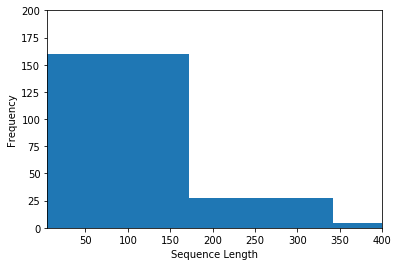

In [57]:
import matplotlib.pyplot as plt
plt.hist(numWords, 28)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axis([5,400 , 0, 200])
plt.show()

<h1>6- Sentiment Analysis </h1>

In [41]:
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Ali\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [58]:
df=df.drop([0], axis=1)
df['scores'] = df['Comments'].apply(lambda review: sid.polarity_scores(review))
df.head()

,Comments,scores
0,If Trump didn't call this a hoax we wouldn't n...,"{'neg': 0.079, 'neu': 0.798, 'pos': 0.123, 'co..."
1,CORRUPT! Really? Here is one guy that should b...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,Who knew that a tv celebrity with zero governm...,"{'neg': 0.294, 'neu': 0.706, 'pos': 0.0, 'comp..."
3,I can see Russia from the YouTube comment sect...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,What about us on SSDI,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."


In [59]:
df['compound']  = df['scores'].apply(lambda score_dict: score_dict['compound'])
df.head()

,Comments,scores,compound
0,If Trump didn't call this a hoax we wouldn't n...,"{'neg': 0.079, 'neu': 0.798, 'pos': 0.123, 'co...",0.3237
1,CORRUPT! Really? Here is one guy that should b...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
2,Who knew that a tv celebrity with zero governm...,"{'neg': 0.294, 'neu': 0.706, 'pos': 0.0, 'comp...",-0.8858
3,I can see Russia from the YouTube comment sect...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
4,What about us on SSDI,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000


In [60]:
df['comp_score'] = df['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')
df.head()

,Comments,scores,compound,comp_score
0,If Trump didn't call this a hoax we wouldn't n...,"{'neg': 0.079, 'neu': 0.798, 'pos': 0.123, 'co...",0.3237,pos
1,CORRUPT! Really? Here is one guy that should b...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos
2,Who knew that a tv celebrity with zero governm...,"{'neg': 0.294, 'neu': 0.706, 'pos': 0.0, 'comp...",-0.8858,neg
3,I can see Russia from the YouTube comment sect...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos
4,What about us on SSDI,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos


In [62]:
df['scores'][0]

{'neg': 0.079, 'neu': 0.798, 'pos': 0.123, 'compound': 0.3237}

<h1>7- Visualize Sentiment Analysis </h1>

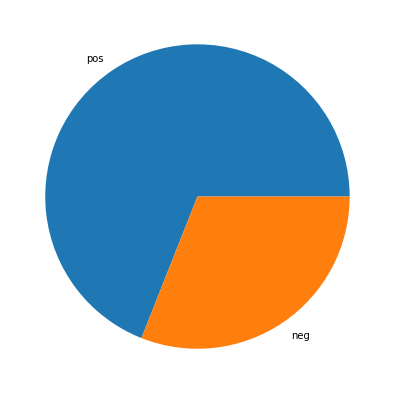

In [63]:
data = df['comp_score'].value_counts() 
labels=data.index
fig = plt.figure(figsize =(10, 7)) 
plt.pie(data, labels = labels) 

# show plot 
plt.show()

<h1>8- Plotting the WordCloud</h1>

In [66]:
# Import packages
import matplotlib.pyplot as plt
%matplotlib inline
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

In [76]:
text=df['Comments'].astype(str)
# Clean text
letters_only = re.sub("[^a-zA-Z]",  # Search for all non-letters
                          " ",          # Replace all non-letters with spaces
                          str(text))


In [81]:
text = re.sub(r'==.*?==+', "", str(text))
text = text.replace('\n', "")
print(text)

0      If Trump didn't call this a hoax we wouldn't n...1      CORRUPT! Really? Here is one guy that should b...2      Who knew that a tv celebrity with zero governm...3      I can see Russia from the YouTube comment sect...4                                  What about us on SSDI                             ...                        195    @Mark Lanzarotta naw china did reality dont fi...196    @Mark Lanzarotta Yeh, he's going door-to-door ...197    @Monica Hennig Hey, everybody! Monica's got a ...198    Sam Ganconi LOL..english must be your 2nd lang...199                    @Richard B standard loser commentName: Comments, Length: 200, dtype: object


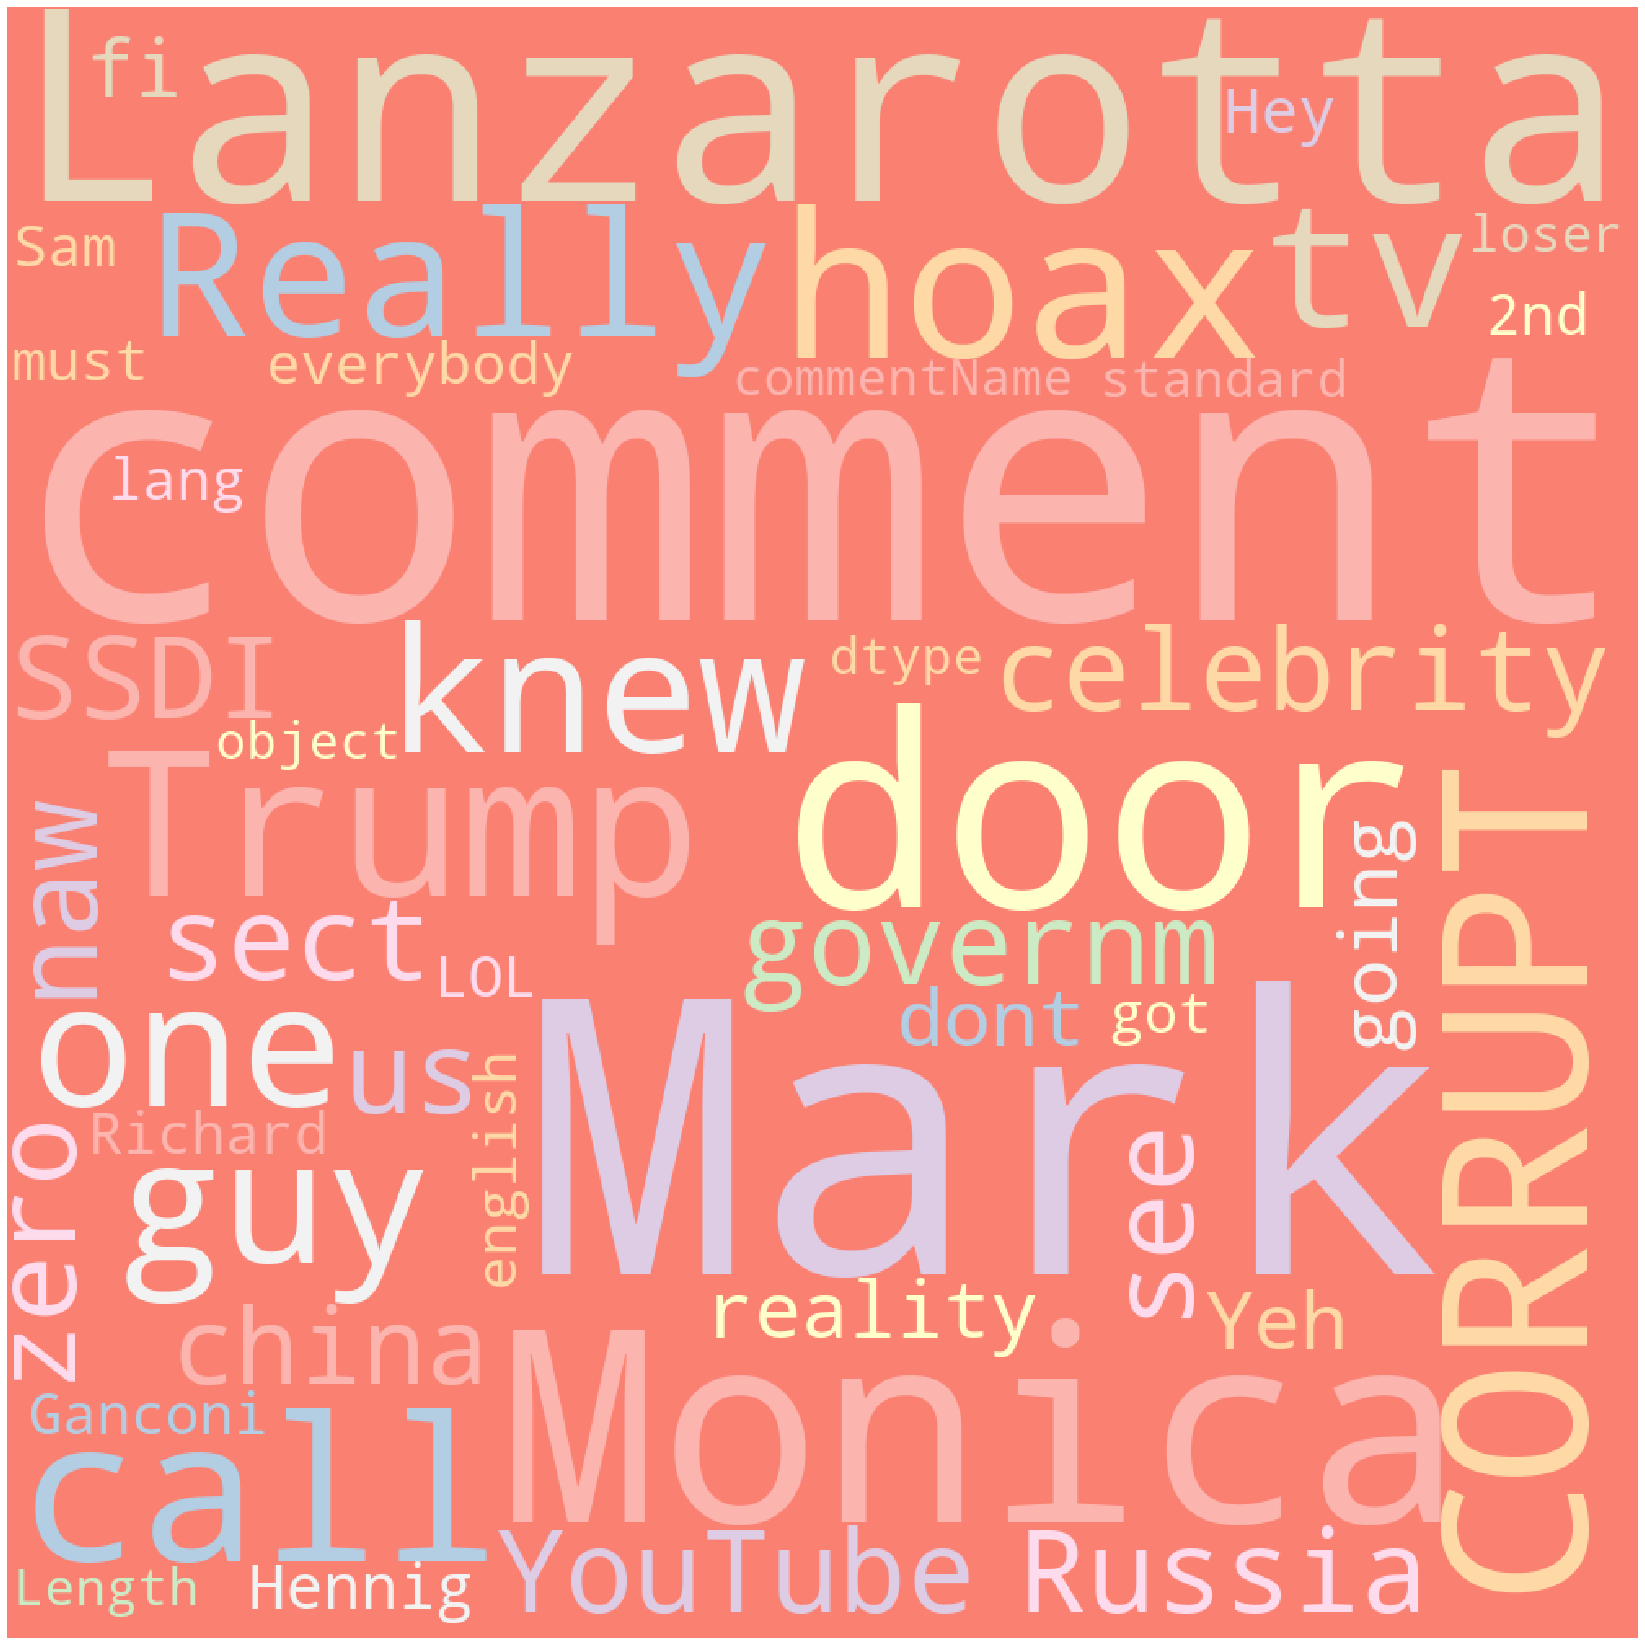

In [83]:
# Import package
from wordcloud import WordCloud, STOPWORDS
# Generate word cloud
wordcloud = WordCloud(width = 1000, height = 1000, random_state=1, background_color='salmon', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(text)
# Plot
plot_cloud(wordcloud)